<a href="https://colab.research.google.com/github/giorgiamazzi/Algorithms-massive-data-project/blob/main/MarketBasketAnalysis_project_GM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Algorithms for Massive Dataset Project

---


Giorgia Mazzi

 **Load** the **dataset** from **Kaggle** 

In [ ]:
from google.colab import files #upload kaggle.json, containing API
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"giorgiamazzi","key":"3e4bdd6972758babbb3327722d0f1f60"}'}

In [ ]:
! pip install -q kaggle 

In [ ]:
! mkdir -p ~/.kaggle #make directory with name Kaggle

In [ ]:
! mv kaggle.json ~/.kaggle/ #move json file into the directory created

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json #give permission to this file

In [ ]:
! kaggle datasets download -d ashirwadsangwan/imdb-dataset

100% 1.44G/1.44G [00:15<00:00, 125MB/s]
100% 1.44G/1.44G [00:15<00:00, 100MB/s]


In [ ]:
!unzip imdb-dataset.zip

Archive:  imdb-dataset.zip
  inflating: name.basics.tsv.gz      
  inflating: name.basics.tsv/name.basics.tsv  
  inflating: title.akas.tsv.gz       
  inflating: title.akas.tsv/title.akas.tsv  
  inflating: title.basics.tsv.gz     
  inflating: title.basics.tsv/title.basics.tsv  
  inflating: title.principals.tsv.gz  
  inflating: title.principals.tsv/title.principals.tsv  
  inflating: title.ratings.tsv.gz    
  inflating: title.ratings.tsv/title.ratings.tsv  


**Spark** Setup

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null  #install Java
!wget -q https://apache.osuosl.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop2.7.tgz #download spark3.0 with hadoop
!tar xf spark-3.2.0-bin-hadoop2.7.tgz #unzip folder

In [ ]:
!pip install -q findspark #locate Spark on the system
import findspark
findspark.init("spark-3.2.0-bin-hadoop2.7")

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64" #set the environmental path that will enable to run Pyspark
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop2.7"

In [ ]:
!pip install pyspark
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

     |████████████████████████████████| 281.3 MB 40 kB/s 
     |████████████████████████████████| 198 kB 64.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=15e9ac458015dfd13e9381a03b713325f27af597b9de207bb04ce301478fbeaf
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark


In [ ]:
spark = SparkSession.builder.getOrCreate()

In [ ]:
sc = spark.sparkContext 

In [ ]:
!pip install python-utils
import numpy as np
import pandas as pd
import seaborn as sns

**Dataset Inspection**


Tables' contents detailed
[url of dataset](https://www.kaggle.com/ashirwadsangwan/imdb-dataset)


In [ ]:
infofornames = spark.read.csv("/content/name.basics.tsv", sep=r'\t', header=True)
infotitleakas = spark.read.csv("/content/title.akas.tsv", sep=r'\t', header=True)
infotitlebasics = spark.read.csv("/content/title.basics.tsv", sep=r'\t', header=True)
castpertitles = spark.read.csv("/content/title.principals.tsv", sep=r'\t', header=True)
ratingandvotes = spark.read.csv("/content/title.ratings.tsv", sep=r'\t', header=True)

In [ ]:
infofornames.createOrReplaceTempView("infofornames")
infotitleakas.createOrReplaceTempView("infotitleakas")
infotitlebasics.createOrReplaceTempView("infotitlebasics")
castpertitles.createOrReplaceTempView("castpertitles")
ratingandvotes.createOrReplaceTempView("ratingandvotes")

In [ ]:
infofornames.show(5)

+---------+---------------+---------+---------+--------------------+--------------------+
|   nconst|    primaryName|birthYear|deathYear|   primaryProfession|      knownForTitles|
+---------+---------------+---------+---------+--------------------+--------------------+
|nm0000001|   Fred Astaire|     1899|     1987|soundtrack,actor,...|tt0050419,tt00531...|
|nm0000002|  Lauren Bacall|     1924|     2014|  actress,soundtrack|tt0071877,tt01170...|
|nm0000003|Brigitte Bardot|     1934|       \N|actress,soundtrac...|tt0054452,tt00491...|
|nm0000004|   John Belushi|     1949|     1982|actor,writer,soun...|tt0077975,tt00725...|
|nm0000005| Ingmar Bergman|     1918|     2007|writer,director,a...|tt0069467,tt00509...|
+---------+---------------+---------+---------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
infotitleakas.show(5)

+---------+--------+--------------------+------+--------+-----------+----------+---------------+
|  titleId|ordering|               title|region|language|      types|attributes|isOriginalTitle|
+---------+--------+--------------------+------+--------+-----------+----------+---------------+
|tt0000001|       1|Carmencita - span...|    HU|      \N|imdbDisplay|        \N|              0|
|tt0000001|       2|          Καρμενσίτα|    GR|      \N|         \N|        \N|              0|
|tt0000001|       3|          Карменсита|    RU|      \N|         \N|        \N|              0|
|tt0000001|       4|          Carmencita|    US|      \N|         \N|        \N|              0|
|tt0000001|       5|          Carmencita|    \N|      \N|   original|        \N|              1|
+---------+--------+--------------------+------+--------+-----------+----------+---------------+
only showing top 5 rows



In [ ]:
infotitlebasics.show(5)

+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|              genres|
+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+--------------------+
|tt0000001|    short|          Carmencita|          Carmencita|      0|     1894|     \N|             1|   Documentary,Short|
|tt0000002|    short|Le clown et ses c...|Le clown et ses c...|      0|     1892|     \N|             5|     Animation,Short|
|tt0000003|    short|      Pauvre Pierrot|      Pauvre Pierrot|      0|     1892|     \N|             4|Animation,Comedy,...|
|tt0000004|    short|         Un bon bock|         Un bon bock|      0|     1892|     \N|            \N|     Animation,Short|
|tt0000005|    short|    Blacksmith Scene|    Blacksmith Scene|      0|     1893|     \N|             1|        Comedy

In [ ]:
castpertitles.show(5)

+---------+--------+---------+---------------+--------------------+-----------+
|   tconst|ordering|   nconst|       category|                 job| characters|
+---------+--------+---------+---------------+--------------------+-----------+
|tt0000001|       1|nm1588970|           self|                  \N|["Herself"]|
|tt0000001|       2|nm0005690|       director|                  \N|         \N|
|tt0000001|       3|nm0374658|cinematographer|director of photo...|         \N|
|tt0000002|       1|nm0721526|       director|                  \N|         \N|
|tt0000002|       2|nm1335271|       composer|                  \N|         \N|
+---------+--------+---------+---------------+--------------------+-----------+
only showing top 5 rows



In [ ]:
ratingandvotes.show(5)

+---------+-------------+--------+
|   tconst|averageRating|numVotes|
+---------+-------------+--------+
|tt0000001|          5.6|    1550|
|tt0000002|          6.1|     186|
|tt0000003|          6.5|    1207|
|tt0000004|          6.2|     113|
|tt0000005|          6.1|    1934|
+---------+-------------+--------+
only showing top 5 rows



**Exploratory Data and Data Cleaning**

For my project, i'd like to implement a system that helps us to find frequent itemsets. Market-basket model of data is a way to represent and describe relationships between objects. In this project I'll use as items (actors) and as baskets (movies). So i want to discover the most frequent actors or actress in movies.
To do the analysis I selected only three csv provided : **infofornames**, **castpertitles**, **infotitlebasics**.

In [ ]:
infofornames = infofornames.filter((infofornames.primaryProfession == 'actor')|(infofornames.primaryProfession == 'actress'))
infofornames.show(5)

+---------+-----------------+---------+---------+-----------------+--------------------+
|   nconst|      primaryName|birthYear|deathYear|primaryProfession|      knownForTitles|
+---------+-----------------+---------+---------+-----------------+--------------------+
|nm0000084|          Li Gong|     1965|       \N|          actress|tt0473444,tt01016...|
|nm0000109|   Yasmine Bleeth|     1968|       \N|          actress|tt0131857,tt01152...|
|nm0000124|Jennifer Connelly|     1970|       \N|          actress|tt0315983,tt01800...|
|nm0000143|    Erika Eleniak|     1969|       \N|          actress|tt0083866,tt00947...|
|nm0000157|   Linda Hamilton|     1956|       \N|          actress|tt0103064,tt64508...|
+---------+-----------------+---------+---------+-----------------+--------------------+
only showing top 5 rows



In [ ]:
infofornames = infofornames.select(['primaryName', 'nconst', 'primaryProfession'])
infofornames = infofornames.withColumnRenamed("primaryName", "Name_actors") \
    .withColumnRenamed("nconst","Id_actors") \
    .withColumnRenamed("primaryProfession","role")
infofornames.printSchema()
infofornames.show(5)

root
 |-- Name_actors: string (nullable = true)
 |-- Id_actors: string (nullable = true)
 |-- role: string (nullable = true)

+-----------------+---------+-------+
|      Name_actors|Id_actors|   role|
+-----------------+---------+-------+
|          Li Gong|nm0000084|actress|
|   Yasmine Bleeth|nm0000109|actress|
|Jennifer Connelly|nm0000124|actress|
|    Erika Eleniak|nm0000143|actress|
|   Linda Hamilton|nm0000157|actress|
+-----------------+---------+-------+
only showing top 5 rows



In [ ]:
spark.sql('''SELECT count(distinct(infofornames.nconst))
              FROM infofornames
              WHERE (infofornames.primaryProfession = 'actor') OR (infofornames.primaryProfession = 'actress')''').show() #2.914.287 actors

+----------------------+
|count(DISTINCT nconst)|
+----------------------+
|               2914287|
+----------------------+



In this way I see that lots of actors that I retrieve (the actors that have played at least one time as actors), they did also other jobs in other films. 

In [ ]:
spark.sql('''SELECT distinct(infofornames.primaryProfession)
              FROM infofornames''').show(20, False) 

+--------------------------------------------------------------+
|primaryProfession                                             |
+--------------------------------------------------------------+
|actress,producer,production_manager                           |
|producer,miscellaneous,location_management                    |
|art_department,miscellaneous,assistant_director               |
|actor,producer,assistant_director                             |
|assistant_director,camera_department,transportation_department|
|assistant_director,actress,director                           |
|miscellaneous,actor,location_management                       |
|miscellaneous,casting_department,actress                      |
|cinematographer,camera_department,talent_agent                |
|make_up_department,actor,costume_designer                     |
|miscellaneous,camera_department,script_department             |
|camera_department,special_effects,visual_effects              |
|production_designer,soun

In [ ]:
spark.sql('''SELECT distinct(castpertitles.category)
              FROM castpertitles''').show() 

+-------------------+
|           category|
+-------------------+
|            actress|
|           producer|
|             writer|
|           composer|
|           director|
|               self|
|              actor|
|             editor|
|    cinematographer|
|      archive_sound|
|production_designer|
|    archive_footage|
+-------------------+



In [ ]:
castpertitles = castpertitles.filter((castpertitles.category == 'actor')|(castpertitles.category == 'actress'))

In [ ]:
castpertitles = castpertitles.select(['tconst', 'nconst', 'category'])
castpertitles = castpertitles.withColumnRenamed("nconst", "Id_actors") \
    .withColumnRenamed("tconst","Id_movie") \
    .withColumnRenamed("category","role")
castpertitles.printSchema()
castpertitles.show(5)

root
 |-- Id_movie: string (nullable = true)
 |-- Id_actors: string (nullable = true)
 |-- role: string (nullable = true)

+---------+---------+-----+
| Id_movie|Id_actors| role|
+---------+---------+-----+
|tt0000005|nm0443482|actor|
|tt0000005|nm0653042|actor|
|tt0000007|nm0179163|actor|
|tt0000007|nm0183947|actor|
|tt0000008|nm0653028|actor|
+---------+---------+-----+
only showing top 5 rows



In [ ]:
spark.sql('''SELECT count(distinct(castpertitles.nconst))
              FROM castpertitles
              WHERE (castpertitles.category = 'actor') OR (castpertitles.category = 'actress')''').show() #1.867.043 actors

+----------------------+
|count(DISTINCT nconst)|
+----------------------+
|               1867043|
+----------------------+



In [ ]:
infotitlebasics = infotitlebasics.filter(infotitlebasics.titleType == 'movie')

In [ ]:
infotitlebasics = infotitlebasics.select(['primaryTitle', 'tconst', 'titleType'])
infotitlebasics = infotitlebasics.withColumnRenamed("primaryTitle", "Name_movie") \
    .withColumnRenamed("tconst","Id_movie") \
    .withColumnRenamed("titleType","movie")
infotitlebasics.printSchema()
infotitlebasics.show(5)

root
 |-- Name_movie: string (nullable = true)
 |-- Id_movie: string (nullable = true)
 |-- movie: string (nullable = true)

+--------------------+---------+-----+
|          Name_movie| Id_movie|movie|
+--------------------+---------+-----+
|          Miss Jerry|tt0000009|movie|
|The Corbett-Fitzs...|tt0000147|movie|
|Soldiers of the C...|tt0000335|movie|
|            Bohemios|tt0000502|movie|
|The Story of the ...|tt0000574|movie|
+--------------------+---------+-----+
only showing top 5 rows



# **Dataset** for the Market Basket Analysis

In [ ]:
infotitle = spark.sql('''SELECT infotitlebasics.tconst AS ID_movie, infotitlebasics.primaryTitle AS TITLE_movie, infotitlebasics.titleType AS category_movie
                                FROM infotitlebasics 
                                WHERE 1=1 
                                AND (infotitlebasics.titleType == 'movie')''')
cast = spark.sql('''SELECT castpertitles.tconst as ID_movie, castpertitles.nconst AS ID_actors, castpertitles.category AS Role_in_movie
                              FROM castpertitles 
                              WHERE 1=1 
                              AND (castpertitles.category = 'actor') OR (castpertitles.category = 'actress')''')

In [ ]:
infotitle.createOrReplaceTempView("infotitle")
cast.createOrReplaceTempView("cast")

In [ ]:
data = spark.sql('''SELECT infotitle.ID_movie as ID_movie, infotitle.TITLE_movie as TITLE_movie, infotitle.category_movie as category_movie, cast.ID_actors as ID_actors, infofornames.primaryName as NAME_actors , cast.Role_in_movie as Role_in_movie
                    FROM (infotitle INNER JOIN cast ON infotitle.ID_movie = cast.ID_movie)
                    INNER JOIN infofornames on cast.ID_actors = infofornames.nconst''')

In [ ]:
data.createOrReplaceTempView("data")

In [ ]:
data.show(5)

+---------+--------------------+--------------+---------+------------+-------------+
| ID_movie|         TITLE_movie|category_movie|ID_actors| NAME_actors|Role_in_movie|
+---------+--------------------+--------------+---------+------------+-------------+
|tt0077621|         Goin' South|         movie|nm0000004|John Belushi|        actor|
|tt0082801|           Neighbors|         movie|nm0000004|John Belushi|        actor|
|tt0077975|National Lampoon'...|         movie|nm0000004|John Belushi|        actor|
|tt0078723|                1941|         movie|nm0000004|John Belushi|        actor|
|tt0080455|  The Blues Brothers|         movie|nm0000004|John Belushi|        actor|
+---------+--------------------+--------------+---------+------------+-------------+
only showing top 5 rows



In [ ]:
print(data.count()) #1.692.939 rows

1692939


In [ ]:
spark.sql('''SELECT category_movie, COUNT(*)
              FROM data
              GROUP BY category_movie''').show() #Check: is there only movies?

+--------------+--------+
|category_movie|count(1)|
+--------------+--------+
|         movie| 1692939|
+--------------+--------+



In [ ]:
spark.sql('''SELECT Role_in_movie, COUNT(*)
              FROM data
              GROUP BY Role_in_movie''').show() #Check: how many actors and actress?

+-------------+--------+
|Role_in_movie|count(1)|
+-------------+--------+
|      actress|  637347|
|        actor| 1055592|
+-------------+--------+



**Checking Null Values**

In [ ]:
spark.sql('''SELECT COUNT(*) 
              FROM data
              WHERE (ID_movie = '/N') OR (TITLE_movie = '/N') OR (ID_actors = '/N') OR (NAME_actors = '/N')''').show()

+--------+
|count(1)|
+--------+
|       0|
+--------+



**Question 1:** 
*Which is the number of actors or actress per film? How many movies have the same number of participants in the cast?*

In [ ]:
groupbymovies = spark.sql('''SELECT ID_movie, TITLE_movie, COUNT(ID_actors) AS number_actors
                    FROM data
                    GROUP BY ID_movie, TITLE_movie
                    ORDER BY number_actors DESC''')

In [ ]:
groupbymovies.show(20)

+----------+--------------------+-------------+
|  ID_movie|         TITLE_movie|number_actors|
+----------+--------------------+-------------+
| tt2543584|        One Day Here|           10|
| tt0160071|Bottom Dweller 5:...|           10|
| tt6735094|           Sathriyan|           10|
| tt3813084|         Jalta Badan|           10|
| tt7153466|sti xagi kai sti ...|           10|
| tt6446750|    Khalik Fe Hallak|           10|
| tt7128038|Exterminator. Fac...|           10|
| tt7440016|           With Love|           10|
| tt7618402|  Change of Gangster|           10|
| tt7162426|    Giafka portokali|           10|
| tt0280055|Putus sudah kasih...|           10|
| tt6764552| Permanent Reminders|           10|
| tt5789676|              Stab 7|           10|
| tt5878312|CHIC: The One Yea...|           10|
| tt0393168|Como agua pa' lon...|           10|
| tt7909340|             Witness|           10|
| tt1641918|      All or Nothing|           10|
|tt11046112|                Haul|       

In [ ]:
from pyspark.sql import functions as f

In [ ]:
moviesbycast = groupbymovies.groupBy('number_actors').agg(f.collect_set('ID_movie').alias('movies'))

In [ ]:
moviesbycast.show()

+-------------+--------------------+
|number_actors|              movies|
+-------------+--------------------+
|           10|[tt7368790, tt361...|
|            9|[tt5134236, tt352...|
|            8|[tt5204858, tt039...|
|            7|[tt0069205, tt007...|
|            6|[tt5229070, tt019...|
|            5|[tt1330991, tt032...|
|            4|[tt8917774, tt154...|
|            3|[tt11011054, tt23...|
|            2|[tt9489044, tt341...|
|            1|[tt0292703, tt933...|
+-------------+--------------------+



In [ ]:
from pyspark.sql.functions import size, col

In [ ]:
moviesbycast = moviesbycast.withColumn("movies",size(col("movies")))

In [ ]:
moviesbycast.show()

+-------------+------+
|number_actors|movies|
+-------------+------+
|           10|  1159|
|            9|  8017|
|            8| 15239|
|            7| 23617|
|            6| 29313|
|            5| 25577|
|            4|221462|
|            3| 22102|
|            2| 18880|
|            1| 28288|
+-------------+------+



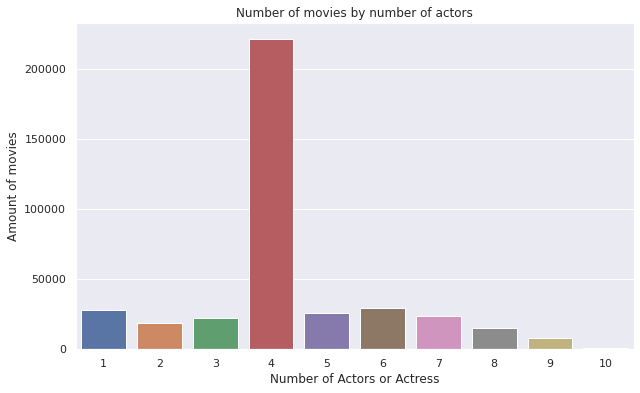

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={"figure.figsize":(10,6)})
ax = sns.barplot(x = "number_actors", y = "movies", data = moviesbycast.toPandas())
ax.set(title = "Number of movies by number of actors", xlabel = "Number of Actors or Actress", ylabel = "Amount of movies"); 

The dataset presents a huge amount of movies with four actors in the cast, while very little number of films with ten actors.

**Question 2:**
*Who are the TOP ten actors that played more movies?* 

In [ ]:
groupbyactors = spark.sql('''SELECT NAME_actors, COUNT(ID_movie) AS number_movies
                              FROM data
                              GROUP BY NAME_actors
                              ORDER BY number_movies DESC
                              LIMIT 11''')

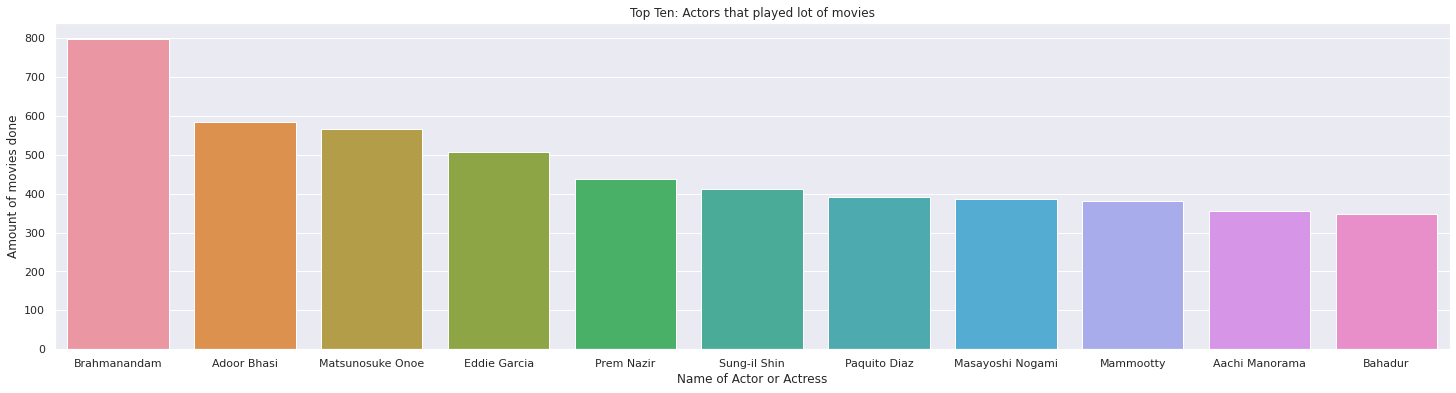

In [ ]:
sns.set_style("darkgrid")
sns.set(rc={"figure.figsize":(25,6)})
ax = sns.barplot(x = "NAME_actors", y = "number_movies", data = groupbyactors.toPandas())
ax.set(title = "Top Ten: Actors that played lot of movies", xlabel = "Name of Actor or Actress", ylabel = "Amount of movies done");

**Baskets for Market Basket Analysis**

In [ ]:
baskets_id= data.groupBy('ID_movie').agg(f.collect_set('ID_actors').alias('actors'))
baskets_id.createOrReplaceTempView('baskets_id')

In [ ]:
baskets_id.show(5)

+---------+--------------------+
| ID_movie|              actors|
+---------+--------------------+
|tt0000335|[nm1012612, nm067...|
|tt0000502|[nm0252720, nm021...|
|tt0000630|         [nm0624446]|
|tt0000676|[nm0140054, nm009...|
|tt0000793|         [nm0691995]|
+---------+--------------------+
only showing top 5 rows



In [ ]:
spark.sql('''SELECT COUNT('ID_movie')
              FROM baskets_id ''').show() #393.654 movies

+---------------+
|count(ID_movie)|
+---------------+
|         393654|
+---------------+



# **FP growth**

The FP-growth algorithm  - explored in the paper Han et al., Mining frequent patterns without candidate generation - as Apriori algorithm tries to calculate item frequencies and identify frequent items. Different from it with the FP-tree structure that encode transactions without generating candidate sets explicitly. 

In [ ]:
from pyspark.ml.fpm import FPGrowth

In [ ]:
FP = FPGrowth(itemsCol="actors", minSupport=0.00003)  #to be frequent more than 10 movies

In [ ]:
model = FP.fit(baskets_id) #it takes 3:40 minutes

In [ ]:
model.freqItemsets.show()
items_set = model.freqItemsets

spark-3.2.0-bin-hadoop2.7/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-----------+----+
|      items|freq|
+-----------+----+
|[nm1700980]|  20|
|[nm0203836]|  46|
|[nm0878546]|  31|
|[nm0226773]|  33|
|[nm0014122]|  20|
|[nm1816849]|  51|
|[nm1954434]|  36|
|[nm1181575]|  15|
|[nm5999008]|  12|
|[nm2761937]|  13|
|[nm0839293]|  15|
|[nm1293253]|  15|
|[nm1122888]|  12|
|[nm0435919]|  15|
|[nm2846617]|  16|
|[nm3156758]|  13|
|[nm0756956]|  12|
|[nm0564691]|  14|
|[nm0952104]|  23|
|[nm0599973]|  20|
+-----------+----+
only showing top 20 rows



In [ ]:
items_set.createOrReplaceTempView("items_set")

In [ ]:
spark.sql('''SELECT items, freq
              FROM items_set
              WHERE size(items) = 1
              ORDER BY freq DESC''').show(10, False)

+-----------+----+
|items      |freq|
+-----------+----+
|[nm0103977]|798 |
|[nm0006982]|585 |
|[nm0648803]|565 |
|[nm0305182]|506 |
|[nm0623427]|438 |
|[nm0793813]|411 |
|[nm0246703]|391 |
|[nm0619107]|387 |
|[nm0007123]|381 |
|[nm7390393]|355 |
+-----------+----+
only showing top 10 rows



In [ ]:
spark.sql('''SELECT count(items)
              FROM items_set
              WHERE size(items) = 1''').show()

+------------+
|count(items)|
+------------+
|       24054|
+------------+



In [ ]:
singleactors = spark.sql('''SELECT items, freq
                            FROM items_set
                            WHERE size(items) = 1
                            ORDER BY freq DESC
                            LIMIT 10''')
singleactors.printSchema()

root
 |-- items: array (nullable = false)
 |    |-- element: string (containsNull = false)
 |-- freq: long (nullable = false)



In [ ]:
namesingleactors_data = spark.sql('''SELECT DISTINCT(ID_actors), NAME_actors
                                    FROM data''')

In [ ]:
from pyspark.sql.functions import concat_ws 

In [ ]:
singleactors = singleactors.withColumn("items", concat_ws(" ",col("items")))
singleactors.printSchema()
singleactors.createOrReplaceTempView("singleactors")

root
 |-- items: string (nullable = false)
 |-- freq: long (nullable = false)



In [ ]:
namesingleactors_data.createOrReplaceTempView("namesingleactors_data")

In [ ]:
spark.sql('''SELECT namesingleactors_data.NAME_actors, singleactors.items, singleactors.freq
              FROM singleactors INNER JOIN namesingleactors_data ON singleactors.items = namesingleactors_data.ID_actors
              ORDER BY singleactors.freq DESC''').show()

+----------------+---------+----+
|     NAME_actors|    items|freq|
+----------------+---------+----+
|    Brahmanandam|nm0103977| 798|
|     Adoor Bhasi|nm0006982| 585|
|Matsunosuke Onoe|nm0648803| 565|
|    Eddie Garcia|nm0305182| 506|
|      Prem Nazir|nm0623427| 438|
|    Sung-il Shin|nm0793813| 411|
|    Paquito Diaz|nm0246703| 391|
|Masayoshi Nogami|nm0619107| 387|
|       Mammootty|nm0007123| 381|
|  Aachi Manorama|nm7390393| 355|
+----------------+---------+----+



The FP Growth algorithm was able to find the same name that we can see in the graph as solution of Question 2, in the same order.

In [ ]:
spark.sql('''SELECT items, freq
              FROM items_set
              WHERE size(items) = 2
              ORDER BY freq DESC''').show(10, False)

+----------------------+----+
|items                 |freq|
+----------------------+----+
|[nm0623427, nm0006982]|237 |
|[nm0046850, nm0006982]|169 |
|[nm0419653, nm0006982]|162 |
|[nm2082516, nm0648803]|147 |
|[nm2373718, nm0648803]|126 |
|[nm0619779, nm0006982]|122 |
|[nm2373718, nm2082516]|113 |
|[nm2077739, nm0648803]|113 |
|[nm0419653, nm0046850]|109 |
|[nm0659173, nm1006879]|103 |
+----------------------+----+
only showing top 10 rows



In [ ]:
spark.sql('''SELECT count(items)
              FROM items_set
              WHERE size(items) = 2''').show()

+------------+
|count(items)|
+------------+
|        3443|
+------------+



In [ ]:
pairsactors = spark.sql('''SELECT items, freq
                            FROM items_set
                            WHERE size(items) = 2
                            ORDER BY freq DESC
                            LIMIT 10''')

In [ ]:
from pyspark.sql.functions import explode

In [ ]:
pairsactors = pairsactors.select(explode(pairsactors.items).alias("items"),"freq")

In [ ]:
pairsactors = pairsactors.withColumn("items", concat_ws(" ", col("items")))
pairsactors.createOrReplaceTempView("pairsactors")
pairsactors.show()

+---------+----+
|    items|freq|
+---------+----+
|nm0623427| 237|
|nm0006982| 237|
|nm0046850| 169|
|nm0006982| 169|
|nm0419653| 162|
|nm0006982| 162|
|nm2082516| 147|
|nm0648803| 147|
|nm2373718| 126|
|nm0648803| 126|
|nm0619779| 122|
|nm0006982| 122|
|nm2373718| 113|
|nm2082516| 113|
|nm2077739| 113|
|nm0648803| 113|
|nm0419653| 109|
|nm0046850| 109|
|nm0659173| 103|
|nm1006879| 103|
+---------+----+



In [ ]:
spark.sql('''SELECT namesingleactors_data.NAME_actors, pairsactors.items, pairsactors.freq
              FROM pairsactors INNER JOIN namesingleactors_data ON pairsactors.items = namesingleactors_data.ID_actors
              ORDER BY pairsactors.freq DESC''').show()

+--------------------+---------+----+
|         NAME_actors|    items|freq|
+--------------------+---------+----+
|         Adoor Bhasi|nm0006982| 237|
|          Prem Nazir|nm0623427| 237|
|             Bahadur|nm0046850| 169|
|         Adoor Bhasi|nm0006982| 169|
|         Adoor Bhasi|nm0006982| 162|
|         Jayabharati|nm0419653| 162|
|    Matsunosuke Onoe|nm0648803| 147|
|        Kijaku Ôtani|nm2082516| 147|
|    Kitsuraku Arashi|nm2373718| 126|
|    Matsunosuke Onoe|nm0648803| 126|
|         Adoor Bhasi|nm0006982| 122|
|Thikkurisi Sukuma...|nm0619779| 122|
|    Kitsuraku Arashi|nm2373718| 113|
|   Suminojo Ichikawa|nm2077739| 113|
|    Matsunosuke Onoe|nm0648803| 113|
|        Kijaku Ôtani|nm2082516| 113|
|         Jayabharati|nm0419653| 109|
|             Bahadur|nm0046850| 109|
|            Panchito|nm0659173| 103|
|              Dolphy|nm1006879| 103|
+--------------------+---------+----+



In [ ]:
spark.sql('''SELECT items, freq
              FROM items_set
              WHERE size(items) = 3
              ORDER BY freq DESC''').show(10, False)

+---------------------------------+----+
|items                            |freq|
+---------------------------------+----+
|[nm2373718, nm2082516, nm0648803]|112 |
|[nm2077739, nm2082516, nm0648803]|100 |
|[nm2077739, nm2373718, nm0648803]|95  |
|[nm2077739, nm2373718, nm2082516]|87  |
|[nm1770187, nm2082516, nm0648803]|80  |
|[nm0419653, nm0046850, nm0006982]|75  |
|[nm0619779, nm0623427, nm0006982]|74  |
|[nm1770187, nm2373718, nm0648803]|70  |
|[nm2384746, nm1698868, nm2366585]|69  |
|[nm2077739, nm1770187, nm0648803]|64  |
+---------------------------------+----+
only showing top 10 rows



In [ ]:
spark.sql('''SELECT count(items)
              FROM items_set
              WHERE size(items) = 3''').show()

+------------+
|count(items)|
+------------+
|         658|
+------------+



In [ ]:
triplesactors = spark.sql('''SELECT items, freq
              FROM items_set
              WHERE size(items) = 3
              ORDER BY freq DESC
              LIMIT 10''')
triplesactors = triplesactors.select(explode(triplesactors.items).alias("items"),"freq")
triplesactors = triplesactors.withColumn("items", concat_ws(" ", col("items")))
triplesactors.createOrReplaceTempView("triplesactors")

In [ ]:
spark.sql('''SELECT namesingleactors_data.NAME_actors, triplesactors.items, triplesactors.freq
              FROM triplesactors INNER JOIN namesingleactors_data ON triplesactors.items = namesingleactors_data.ID_actors
              ORDER BY triplesactors.freq DESC''').show()

+--------------------+---------+----+
|         NAME_actors|    items|freq|
+--------------------+---------+----+
|    Matsunosuke Onoe|nm0648803| 112|
|    Kitsuraku Arashi|nm2373718| 112|
|        Kijaku Ôtani|nm2082516| 112|
|   Suminojo Ichikawa|nm2077739| 100|
|        Kijaku Ôtani|nm2082516| 100|
|    Matsunosuke Onoe|nm0648803| 100|
|    Matsunosuke Onoe|nm0648803|  95|
|    Kitsuraku Arashi|nm2373718|  95|
|   Suminojo Ichikawa|nm2077739|  95|
|        Kijaku Ôtani|nm2082516|  87|
|    Kitsuraku Arashi|nm2373718|  87|
|   Suminojo Ichikawa|nm2077739|  87|
|    Matsunosuke Onoe|nm0648803|  80|
| Sen'nosuke Nakamura|nm1770187|  80|
|        Kijaku Ôtani|nm2082516|  80|
|         Adoor Bhasi|nm0006982|  75|
|             Bahadur|nm0046850|  75|
|         Jayabharati|nm0419653|  75|
|         Adoor Bhasi|nm0006982|  74|
|Thikkurisi Sukuma...|nm0619779|  74|
+--------------------+---------+----+
only showing top 20 rows



In [ ]:
spark.sql('''SELECT items, freq
              FROM items_set
              WHERE size(items) = 4
              ORDER BY freq DESC''').show(10, False)

+--------------------------------------------+----+
|items                                       |freq|
+--------------------------------------------+----+
|[nm2077739, nm2373718, nm2082516, nm0648803]|86  |
|[nm1770187, nm2373718, nm2082516, nm0648803]|62  |
|[nm2077739, nm1770187, nm2082516, nm0648803]|54  |
|[nm2077739, nm1770187, nm2373718, nm0648803]|51  |
|[nm2367854, nm2384746, nm1698868, nm2366585]|51  |
|[nm2373151, nm2373718, nm2082516, nm0648803]|48  |
|[nm1283907, nm2373718, nm2082516, nm0648803]|46  |
|[nm2077739, nm1770187, nm2373718, nm2082516]|45  |
|[nm2373151, nm2077739, nm2082516, nm0648803]|45  |
|[nm2373151, nm2077739, nm2373718, nm0648803]|44  |
+--------------------------------------------+----+
only showing top 10 rows



In [ ]:
spark.sql('''SELECT count(items)
              FROM items_set
              WHERE size(items) = 4''').show()

+------------+
|count(items)|
+------------+
|         315|
+------------+



In [ ]:
quadruplesactors = spark.sql('''SELECT items, freq
              FROM items_set
              WHERE size(items) = 4
              ORDER BY freq DESC
              LIMIT 10''')
quadruplesactors = quadruplesactors.select(explode(quadruplesactors.items).alias("items"),"freq")
quadruplesactors = quadruplesactors.withColumn("items", concat_ws(" ", col("items")))
quadruplesactors.createOrReplaceTempView("quadruplesactors")

In [ ]:
spark.sql('''SELECT namesingleactors_data.NAME_actors, quadruplesactors.items, quadruplesactors.freq
              FROM quadruplesactors INNER JOIN namesingleactors_data ON quadruplesactors.items = namesingleactors_data.ID_actors
              ORDER BY quadruplesactors.freq DESC''').show()

+-------------------+---------+----+
|        NAME_actors|    items|freq|
+-------------------+---------+----+
|       Kijaku Ôtani|nm2082516|  86|
|  Suminojo Ichikawa|nm2077739|  86|
|   Matsunosuke Onoe|nm0648803|  86|
|   Kitsuraku Arashi|nm2373718|  86|
|   Kitsuraku Arashi|nm2373718|  62|
|   Matsunosuke Onoe|nm0648803|  62|
|       Kijaku Ôtani|nm2082516|  62|
|Sen'nosuke Nakamura|nm1770187|  62|
|Sen'nosuke Nakamura|nm1770187|  54|
|   Matsunosuke Onoe|nm0648803|  54|
|  Suminojo Ichikawa|nm2077739|  54|
|       Kijaku Ôtani|nm2082516|  54|
|Sen'nosuke Nakamura|nm1770187|  51|
|      Ritoku Arashi|nm2366585|  51|
|        Hôshô Bandô|nm2384746|  51|
|  Suminojo Ichikawa|nm2077739|  51|
|   Matsunosuke Onoe|nm0648803|  51|
|       Shôzô Arashi|nm2367854|  51|
|    Enshô Jitsukawa|nm1698868|  51|
|   Kitsuraku Arashi|nm2373718|  51|
+-------------------+---------+----+
only showing top 20 rows



In [ ]:
model.associationRules.show()
rules = model.associationRules

spark-3.2.0-bin-hadoop2.7/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+--------------------+-----------+------------------+------------------+--------------------+
|          antecedent| consequent|        confidence|              lift|             support|
+--------------------+-----------+------------------+------------------+--------------------+
|[nm0931054, nm041...|[nm0001889]|               0.8|           9841.35|3.048362267371854...|
|[nm1283907, nm064...|[nm2373718]|0.8909090909090909|2739.9213068181816|1.244747925843507...|
|[nm1283907, nm064...|[nm2082516]|0.9272727272727272|2267.2336533032185|1.295553963633038E-4|
|[nm0799982, nm080...|[nm0482121]|               1.0| 8946.681818181818|7.112845290534328E-5|
|[nm2679281, nm029...|[nm2394215]|             0.875|3785.1346153846157|3.556422645267164E-5|
|[nm2679281, nm029...|[nm0945427]|               1.0|1805.7522935779816|4.064483023162473E-5|
|[nm4050725, nm167...|[nm0314775]|            0.9375|16775.028409090908|3.810452834214818E-5|
|[nm4050725, nm167...|[nm2846621]|            0.9375| 19423.

In [ ]:
rules.createOrReplaceTempView("rules")
rules.sort(rules.lift.desc()).show(10, False)
descrules = rules.sort(rules.lift.desc())
descrules.createOrReplaceTempView("descrules")

+--------------------------------------------+-----------+------------------+------------------+---------------------+
|antecedent                                  |consequent |confidence        |lift              |support              |
+--------------------------------------------+-----------+------------------+------------------+---------------------+
|[nm0004310]                                 |[nm0002935]|1.0               |32804.5           |3.0483622673718545E-5|
|[nm0002935]                                 |[nm0004310]|1.0               |32804.5           |3.0483622673718545E-5|
|[nm6774606]                                 |[nm6774610]|1.0               |28118.142857142855|3.556422645267164E-5 |
|[nm6774608, nm2811639, nm6774609, nm6774610]|[nm6774607]|1.0               |28118.142857142855|3.302392456319509E-5 |
|[nm2811639, nm6774610]                      |[nm6774607]|1.0               |28118.142857142855|3.556422645267164E-5 |
|[nm2811639, nm6774606]                      |[n

In [ ]:
firstrow_descrules = spark.sql('''SELECT *
                                  FROM descrules
                                  LIMIT 1''')
firstrow_descrules.show(1,False)

+-----------+-----------+----------+-------+---------------------+
|antecedent |consequent |confidence|lift   |support              |
+-----------+-----------+----------+-------+---------------------+
|[nm0002935]|[nm0004310]|1.0       |32804.5|3.0483622673718545E-5|
+-----------+-----------+----------+-------+---------------------+



In [ ]:
spark.sql('''SELECT namesingleactors_data.NAME_actors, namesingleactors_data.ID_actors
              FROM namesingleactors_data
              WHERE namesingleactors_data.ID_actors IN ('nm0002935', 'nm0004310')''').show()

+-----------+---------+
|NAME_actors|ID_actors|
+-----------+---------+
| Moe Howard|nm0002935|
| Larry Fine|nm0004310|
+-----------+---------+



In [ ]:
rules.sort(rules.lift.asc()).show(10, False)
ascrules = rules.sort(rules.lift.asc())
ascrules.createOrReplaceTempView("ascrules")

+---------------------------------+-----------+------------------+-----------------+---------------------+
|antecedent                       |consequent |confidence        |lift             |support              |
+---------------------------------+-----------+------------------+-----------------+---------------------+
|[nm0648300, nm0619779, nm0623427]|[nm0006982]|0.8               |538.3302564102564|3.0483622673718545E-5|
|[nm2133977, nm1588355]           |[nm0006982]|0.8               |538.3302564102564|3.0483622673718545E-5|
|[nm0451005, nm1588355]           |[nm0006982]|0.8               |538.3302564102564|3.0483622673718545E-5|
|[nm0024301, nm0623427]           |[nm0006982]|0.8181818181818182|550.565034965035 |4.5725434010577816E-5|
|[nm1588355, nm0623427]           |[nm0006982]|0.8275862068965517|556.8933687002652|6.096724534743709E-5 |
|[nm2414317, nm2369538, nm2077739]|[nm0648803]|0.8               |557.3861946902655|3.0483622673718545E-5|
|[nm0619779, nm0046850, nm0623427]|[n

**FP Growth** with a **restrictive** **threshold**

In [ ]:
FP_minsup = FPGrowth(itemsCol="actors", minSupport=0.00033) #to be frequent 130 movies
model_minsup = FP_minsup.fit(baskets_id) #it takes 3 min

In [ ]:
rules_minsup = model_minsup.associationRules
rules_minsup.createOrReplaceTempView("rules_minsup")
rules_minsup.sort(rules_minsup.lift.desc()).show(20, False)

spark-3.2.0-bin-hadoop2.7/python/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


+-----------+-----------+------------------+-----------------+---------------------+
|antecedent |consequent |confidence        |lift             |support              |
+-----------+-----------+------------------+-----------------+---------------------+
|[nm2082516]|[nm0648803]|0.9130434782608695|636.1472874182377|3.7342437775305217E-4|
+-----------+-----------+------------------+-----------------+---------------------+



In [ ]:
spark.sql('''SELECT namesingleactors_data.NAME_actors as FPgrowth_pair
              FROM namesingleactors_data
              WHERE namesingleactors_data.ID_actors IN ('nm2082516', 'nm0648803')''').show()

+----------------+
|   FPgrowth_pair|
+----------------+
|Matsunosuke Onoe|
|    Kijaku Ôtani|
+----------------+



# **Apriori Algorithm**


In [ ]:
transactions = baskets_id.select('actors').rdd.flatMap(lambda x: x)

In [ ]:
transactions.take(4)

[['nm1012612',
  'nm0675260',
  'nm1012621',
  'nm1010955',
  'nm0675239',
  'nm1011210'],
 ['nm0252720', 'nm0215752'],
 ['nm0624446'],
 ['nm0140054', 'nm0097421']]

In [ ]:
list_flat =  transactions.flatMap(list) 
singleitem = list_flat.map(lambda item: (item , 1))

In [ ]:
singleitem.take(2)

[('nm1012612', 1), ('nm0675260', 1)]

In [ ]:
def SumCount(x,y):
    return x+y

In [ ]:
support = singleitem.reduceByKey(SumCount)

In [ ]:
support.take(2)

[('nm1012621', 1), ('nm1011210', 1)]

In [ ]:
supports = support.map(lambda item: item[1])

In [ ]:
supports.take(2)

[1, 1]

In [ ]:
minSupport = 130

In [ ]:
support = support.filter(lambda item: item[1] >= minSupport )

In [ ]:
support.take(2)

[('nm0225905', 151), ('nm0435229', 138)]

In [ ]:
singlerdd = support.map(lambda item: ([item[0]] , item[1])) 

In [ ]:
singlerdd.take(2)

[(['nm0225905'], 151), (['nm0435229'], 138)]

In [ ]:
frequent_actors = support.map(lambda item: (item[0]))

In [ ]:
frequent_actors.take(2)

['nm0225905', 'nm0435229']

In [ ]:
columns = ["actor", "frequent"]
candidates_actors = singlerdd.toDF(columns)
candidates_actors.createOrReplaceTempView("candidates_actors")

spark.sql('''SELECT *
              FROM candidates_actors
              ORDER BY frequent DESC''').show(10, False)

+-----------+--------+
|actor      |frequent|
+-----------+--------+
|[nm0103977]|798     |
|[nm0006982]|585     |
|[nm0648803]|565     |
|[nm0305182]|506     |
|[nm0623427]|438     |
|[nm0793813]|411     |
|[nm0246703]|391     |
|[nm0619107]|387     |
|[nm0007123]|381     |
|[nm7390393]|355     |
+-----------+--------+
only showing top 10 rows



In [ ]:
candidates_actors = candidates_actors.withColumn("actor", concat_ws(" ",col("actor")))
candidates_actors.createOrReplaceTempView("candidates_actors")

In [ ]:
spark.sql('''SELECT namesingleactors_data.NAME_actors, candidates_actors.actor, candidates_actors.frequent
              FROM candidates_actors INNER JOIN namesingleactors_data ON candidates_actors.actor = namesingleactors_data.ID_actors
              ORDER BY candidates_actors.frequent DESC''').show()

+------------------+---------+--------+
|       NAME_actors|    actor|frequent|
+------------------+---------+--------+
|      Brahmanandam|nm0103977|     798|
|       Adoor Bhasi|nm0006982|     585|
|  Matsunosuke Onoe|nm0648803|     565|
|      Eddie Garcia|nm0305182|     506|
|        Prem Nazir|nm0623427|     438|
|      Sung-il Shin|nm0793813|     411|
|      Paquito Diaz|nm0246703|     391|
|  Masayoshi Nogami|nm0619107|     387|
|         Mammootty|nm0007123|     381|
|    Aachi Manorama|nm7390393|     355|
|           Bahadur|nm0046850|     348|
|          Mohanlal|nm0482320|     344|
|Mithun Chakraborty|nm0149822|     330|
|   Shivaji Ganesan|nm0304262|     323|
|       Sultan Rahi|nm0706691|     315|
|            Nagesh|nm0619309|     313|
|     Shakti Kapoor|nm0007106|     310|
|       Pandharibai|nm0659250|     303|
|         Tom Byron|nm0001000|     303|
|       Jayabharati|nm0419653|     303|
+------------------+---------+--------+
only showing top 20 rows



The frequent single actors that Apriori find are the same that we found in FP growth, in the same order.

In [ ]:
print(frequent_actors.count()) 

324


In [ ]:
import itertools

In [ ]:
 pairs_list = list(itertools.combinations(frequent_actors.toLocalIterator(),2))

In [ ]:
def removef (rdd, list_items):
  for item in list_items:
    if set(list(item)).issubset(set(rdd)): 
      return((item, 1))

In [ ]:
support_pairs = transactions.map(lambda x: removef(x, pairs_list)).filter(lambda x: x is not None)

In [ ]:
support_pairs.take(2)

[(('nm0392442', 'nm0369058'), 1), (('nm0392442', 'nm0001935'), 1)]

In [ ]:
sum_support_pairs= support_pairs.reduceByKey(SumCount)

In [ ]:
candidates_pair = sum_support_pairs.filter(lambda item: item[1] >= minSupport)

In [ ]:
candidates_pairs = candidates_pair.map(lambda item: ([item[0]] , item[1])) 

In [ ]:
columnspairs = ["pairs", "frequent"]
pairs = candidates_pairs.toDF(columnspairs)
pairs.createOrReplaceTempView("pairs")

spark.sql('''SELECT *
              FROM pairs
              ORDER BY frequent DESC''').show(10, False) #it takes 4h 

+------------------------+--------+
|pairs                   |frequent|
+------------------------+--------+
|[{nm2082516, nm0648803}]|146     |
+------------------------+--------+



In [ ]:
spark.sql('''SELECT namesingleactors_data.NAME_actors, namesingleactors_data.ID_actors
              FROM namesingleactors_data 
              WHERE ID_actors in ('nm2082516','nm0648803')''').show()

+----------------+---------+
|     NAME_actors|ID_actors|
+----------------+---------+
|Matsunosuke Onoe|nm0648803|
|    Kijaku Ôtani|nm2082516|
+----------------+---------+



In [ ]:
spark.sql('''SELECT candidates_actors.actor, candidates_actors.frequent
              FROM candidates_actors
              WHERE candidates_actors.actor in ('nm2082516','nm0648803') ''').show()

+---------+--------+
|    actor|frequent|
+---------+--------+
|nm2082516|     161|
|nm0648803|     565|
+---------+--------+



**Confidence** and **Lift** of the Apriori frequent pair

In [ ]:
Confidence_nm2082516_nm0648803 = round(146/161, 2)

In [ ]:
print(Confidence_nm2082516_nm0648803)

0.91


In [ ]:
value = round((161*565)/393654, 2) 
lift_pair = round((146/value), 2)
print(lift_pair)

634.78


**Check** on **results**

In [ ]:
movies_of_Matsunosuke_Onoe = spark.sql('''SELECT ID_movie, TITLE_movie
                                FROM data
                                WHERE (ID_actors = 'nm0648803')''') 

In [ ]:
movies_of_Kijaku_Otani = spark.sql('''SELECT ID_movie, TITLE_movie
                                FROM data
                                WHERE (ID_actors = 'nm2082516')''') 

In [ ]:
movies_of_Matsunosuke_Onoe.createOrReplaceTempView("movies_of_Matsunosuke_Onoe")
movies_of_Kijaku_Otani.createOrReplaceTempView("movies_of_Kijaku_Otani")

Movies of the Frequent pair

In [ ]:
spark.sql('''SELECT a.TITLE_movie
              FROM movies_of_Matsunosuke_Onoe a INNER JOIN movies_of_Kijaku_Otani b on a.ID_movie = b.ID_movie''').show(15, False)

+----------------------+
|TITLE_movie           |
+----------------------+
|Nidaime jiraiya       |
|Onigoroshi juzô       |
|Gôsho Kingôro         |
|Moyuru uzumaki sanbu  |
|Araki Mataemon        |
|Kantô shichinin otoko |
|Chûshingura           |
|Yakko no kôsan        |
|Meitô takada matabei  |
|Benten kozo           |
|Go henge kikûmatsu    |
|Yoshioka Kanefusa     |
|Gôsho no Gorozô       |
|Kana tehon chûsinghura|
|Takenâka hanbei       |
+----------------------+
only showing top 15 rows



In [ ]:
title_movies_frequentpair = spark.sql('''SELECT a.TITLE_movie
                                        FROM movies_of_Matsunosuke_Onoe a INNER JOIN movies_of_Kijaku_Otani b on a.ID_movie = b.ID_movie''')
title_movies_frequentpair.createOrReplaceTempView("title_movies_frequentpair")
spark.sql('''SELECT count(distinct(TITLE_movie))
              FROM title_movies_frequentpair''').show()

+---------------------------+
|count(DISTINCT TITLE_movie)|
+---------------------------+
|                        146|
+---------------------------+



In [ ]:
spark.sql('''SELECT b.TITLE_movie, a.*
              FROM infotitlebasics a INNER JOIN title_movies_frequentpair b on a.primaryTitle = b.TITLE_movie
              WHERE (a.titleType == 'movie')''').show()

+--------------------+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+------+
|         TITLE_movie|   tconst|titleType|        primaryTitle|       originalTitle|isAdult|startYear|endYear|runtimeMinutes|genres|
+--------------------+---------+---------+--------------------+--------------------+-------+---------+-------+--------------+------+
|       Yurei hannôjô|tt1068870|    movie|       Yurei hannôjô|       Yurei hannôjô|      0|     1917|     \N|            \N|    \N|
|         Nihon ginji|tt1095100|    movie|         Nihon ginji|         Nihon ginji|      0|     1918|     \N|            \N|    \N|
|     Natsume sentarô|tt1075367|    movie|     Natsume sentarô|     Natsume sentarô|      0|     1917|     \N|            \N|    \N|
|     Nichigetsû tarô|tt1066465|    movie|     Nichigetsû tarô|     Nichigetsû tarô|      0|     1916|     \N|            \N|    \N|
|    Kairiki shinkchi|tt1093834|    movie|    Kairiki shinkchi|    Ka